# Hello Tensorflow Too

## test 1: MNIST convolutional autoencoder with tf.data.Datasets & tf.keras

a basic convnet-based encoder-decoder autoencoder for MNIST digits.

using the same convolutional model as the classification task for our encoder, we compress the information into a (4, 4, 4) matrix.

then we use a transposed convolutional decoder to "blow up" the image, conditioning the model on the original input.



In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from functools import reduce

In [3]:
tf.__version__

'2.0.0-beta1'

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# add axis for channel and normalize to 0 ~ 1 (based on training max)
x_test = np.expand_dims(x_test, axis=-1)/np.max(x_train)
x_train = np.expand_dims(x_train, axis=-1)/np.max(x_train)
x_shape = x_train[0].shape
print(np.min(x_train), np.max(x_train))
print(x_train.shape)

0.0 1.0
(60000, 28, 28, 1)


In [5]:
trn_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
trn_dataset = trn_dataset.shuffle(buffer_size=128).batch(32, drop_remainder=True)

In [6]:
tst_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test))
tst_dataset = tst_dataset.shuffle(buffer_size=128).batch(32, drop_remainder=True)

In [7]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, kernel_size=2, activation='relu', strides=2, input_shape=x_shape, name='conv2d_a'),
    tf.keras.layers.Dropout(rate=0.2, name='dropout_a'),
    tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', strides=1, name='conv2d_b'),
    tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', strides=1, name='conv2d_c'),
    tf.keras.layers.Dropout(rate=0.2, name='dropout_b'),
    tf.keras.layers.Conv2D(8, kernel_size=4, activation='relu', strides=1, name='conv2d_d'),
    tf.keras.layers.Conv2D(4, kernel_size=2, activation='tanh', name='conv2d_e'),
    tf.keras.layers.Flatten(name='flat_latents')
], name='encoder')

In [8]:
enc_out_shape = tuple(encoder.layers[-1].output.shape[1:])

print("compressing {} features to size {} = compression factor of {:3.1f}x".format(
    reduce(lambda x, y: x*y, x_shape),
    reduce(lambda x, y: x*y, enc_out_shape),
    reduce(lambda x, y: x*y, x_shape)/reduce(lambda x, y: x*y, enc_out_shape)
))

compressing 784 features to size 64 = compression factor of 12.2x


In [9]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_a (Conv2D)            (None, 14, 14, 8)         40        
_________________________________________________________________
dropout_a (Dropout)          (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_b (Conv2D)            (None, 11, 11, 8)         1032      
_________________________________________________________________
conv2d_c (Conv2D)            (None, 8, 8, 8)           1032      
_________________________________________________________________
dropout_b (Dropout)          (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_d (Conv2D)            (None, 5, 5, 8)           1032      
_________________________________________________________________
conv2d_e (Conv2D)            (None, 4, 4, 4)           132 

In [10]:
decoder = tf.keras.Sequential([
    tf.keras.layers.Reshape((4, 4, 4), input_shape=enc_out_shape, name='reshape_latents'),
    tf.keras.layers.Conv2DTranspose(8, kernel_size=4, dilation_rate=2, activation='tanh', name='deconv_1'),
    tf.keras.layers.Conv2DTranspose(8, kernel_size=4, dilation_rate=2, activation='tanh', name='deconv_2'),
    tf.keras.layers.Conv2DTranspose(8, kernel_size=4, dilation_rate=2, activation='tanh', name='deconv_3'),
    tf.keras.layers.Conv2DTranspose(8, kernel_size=4, dilation_rate=2, activation='tanh', name='deconv_4'),
    tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid', name='final_conv')
    
], name='decoder')

In [11]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_latents (Reshape)    (None, 4, 4, 4)           0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 10, 10, 8)         520       
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 16, 16, 8)         1032      
_________________________________________________________________
deconv_3 (Conv2DTranspose)   (None, 22, 22, 8)         1032      
_________________________________________________________________
deconv_4 (Conv2DTranspose)   (None, 28, 28, 8)         1032      
_________________________________________________________________
final_conv (Conv2D)          (None, 28, 28, 1)         9         
Total params: 3,625
Trainable params: 3,625
Non-trainable params: 0
_________________________________________________________

In [12]:
p2pmdl = tf.keras.Sequential([
    encoder,
    decoder], name='autoencoder')

In [13]:
p2pmdl.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.BinaryCrossentropy(), # or MSE?
               metrics=[tf.keras.metrics.MeanSquaredError()])

In [14]:
p2pmdl.fit(trn_dataset, epochs=10, verbose=2)

W0620 18:19:35.095201 140530270484224 deprecation.py:323] From /home/derek/miniconda3/envs/tf2beta/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
1875/1875 - 23s - loss: 0.2200 - mean_squared_error: 0.0498
Epoch 2/10
1875/1875 - 22s - loss: 0.1703 - mean_squared_error: 0.0344
Epoch 3/10
1875/1875 - 21s - loss: 0.1590 - mean_squared_error: 0.0311
Epoch 4/10
1875/1875 - 21s - loss: 0.1541 - mean_squared_error: 0.0296
Epoch 5/10
1875/1875 - 22s - loss: 0.1512 - mean_squared_error: 0.0287
Epoch 6/10
1875/1875 - 21s - loss: 0.1490 - mean_squared_error: 0.0281
Epoch 7/10
1875/1875 - 22s - loss: 0.1475 - mean_squared_error: 0.0276
Epoch 8/10
1875/1875 - 21s - loss: 0.1463 - mean_squared_error: 0.0272
Epoch 9/10
1875/1875 - 22s - loss: 0.1453 - mean_squared_error: 0.0269
Epoch 10/10
1875/1875 - 21s - loss: 0.1444 - mean_squared_error: 0.0267


In [15]:
p2pmdl.evaluate(tst_dataset)

312/312 [==============================] - 2s 6ms/step - loss: 0.1383 - mean_squared_error: 0.0246


[0.13828219406497785, 0.024627373]

In [16]:
outs = p2pmdl.predict(x_test)
outs = outs.squeeze(axis=-1)

In [17]:
inps = x_test.squeeze(axis=-1)

In [18]:
indices = np.random.randint(0, len(x_test), size=16)

In [19]:
def renderdigits(plots, indices):
    fig = plt.figure( figsize=(14,6) )
    for i in range(0,15):
        ax = fig.add_subplot(3,5,i+1)
        ax.imshow(plots[indices[i]], cmap='gray')
    plt.show()
    return

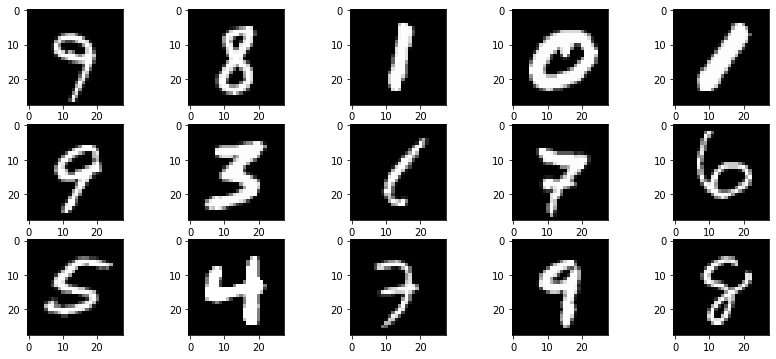

In [20]:
renderdigits(inps, indices)

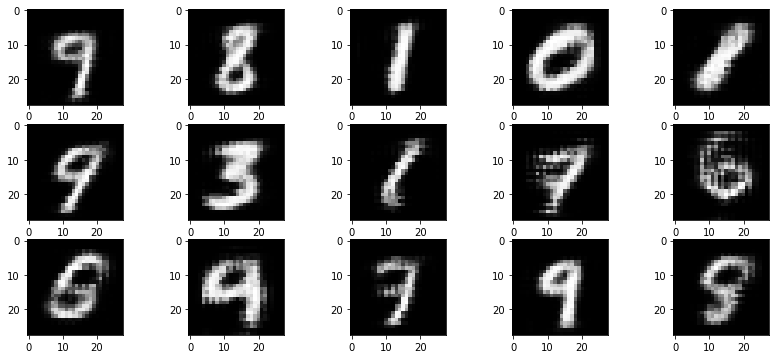

In [21]:
renderdigits(outs, indices)